# PyTorch MNIST Classifier

This notebook demonstrates a simple image classifier using PyTorch on the MNIST dataset.

## Steps:
1. Setup device (CPU/GPU/MPS)
2. Load and transform data
3. Define the Convolutional Neural Network (CNN)
4. Train the model
5. Evaluate accuracy

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check for GPU/MPS
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 5

In [3]:
# Data Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # MNIST Mean and Std
])

# Download and Load MNIST Dataset
# This will create a 'data' folder in the current directory
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training samples: 60000
Test samples: 10000


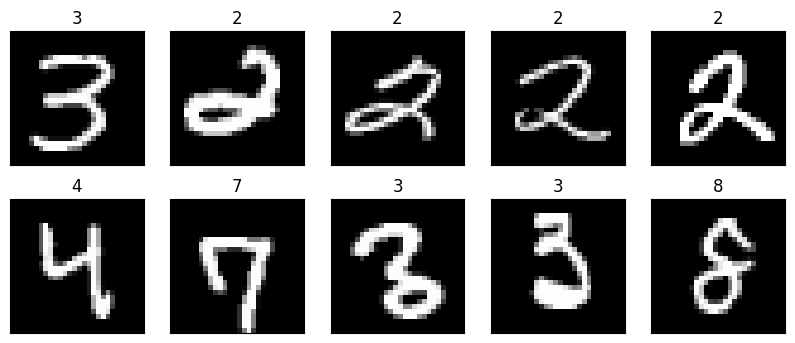

In [4]:
# Helper function to show a batch of images
def show_batch(loader):
    images, labels = next(iter(loader))
    fig = plt.figure(figsize=(10, 4))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(str(labels[i].item()))
    plt.show()

show_batch(train_loader)

In [5]:
# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [6]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
# Training Function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

In [8]:
# Test Function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [9]:
# Main Training Loop
for epoch in range(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334159
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.197382
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.152476
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.156240
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.107860
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.046012
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.043538
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.095460
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.011808
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.109009

Test set: Average loss: 0.0008, Accuracy: 9839/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.006748
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.106216
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.184661
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.043329
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.081929
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.032546
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.022029
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.036650
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.027711
T

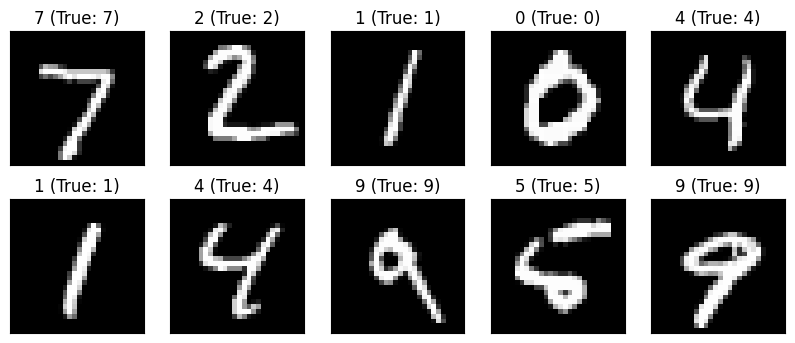

In [10]:
# Visualize some predictions
def visualize_predictions(model, device, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = outputs.argmax(dim=1)
    
    # Move data back to CPU for plotting
    images = images.cpu()
    preds = preds.cpu()
    
    fig = plt.figure(figsize=(10, 4))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"{preds[i].item()} (True: {labels[i].item()})")
    plt.show()

visualize_predictions(model, device, test_loader)